In [ ]:
%%capture
%config Completer.use_jedi = False
%config InlineBackend.figure_formats = ['svg']
import os

STATIC_WEB_PAGE = {"EXECUTE_NB", "READTHEDOCS"}.intersection(os.environ)

# Install on Google Colab
import subprocess
import sys

from IPython import get_ipython

install_packages = "google.colab" in str(get_ipython())
if install_packages:
    for package in ["tensorwaves[doc]", "graphviz"]:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", package]
        )

<!-- cspell:disable -->

# Usage

**Check whether or not TensorFlow is installed:**

In [ ]:
!pip freeze | grep tensorflow

tensorflow==2.5.0
tensorflow-cpu==2.5.0
tensorflow-estimator==2.5.0
tensorflow-probability==0.12.2


TensorWaves is a package for fitting general mathematical expressions to data distributions. The fundamentals behind the package are illustrated in {doc}`/usage/basics`.

While general in design, the package is intended for doing {doc}`Partial Wave Analysis <pwa:index>`. First, the {mod}`ampform` package determines which transitions are allowed from some initial state to a final state. It then formulates those transitions mathematically as an {ref}`amplitude model <usage:Construct a model>`. TensorWaves can then {meth}`~.Model.lambdify` this expression to some computational backend. Finally, TensorWaves {ref}`'fits' <usage:Optimize the model>` this model to some data sample. Optionally, a data sample can be {ref}`generated <usage:Generate data sample>` from the model.

This page shows a brief overview of the complete workflow. More info about each step can be found under {ref}`usage:Step-by-step workflow`.

## Overview

### Construct a model

:::{seealso}

{doc}`usage/step1`

:::

In [ ]:
import warnings

import ampform
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import qrules as q
from ampform.dynamics.builder import create_relativistic_breit_wigner_with_ff

from tensorwaves.data import generate_data, generate_phsp
from tensorwaves.data.transform import HelicityTransformer
from tensorwaves.estimator import UnbinnedNLL
from tensorwaves.model import LambdifiedFunction, SympyModel
from tensorwaves.optimizer.callbacks import CSVSummary
from tensorwaves.optimizer.minuit import Minuit2

warnings.filterwarnings("ignore")

:::{margin}

This example fits a simple model. See {doc}`/usage/step1` for a more complicated model.

:::

Propagating quantum numbers:   0%|          | 0/16 [00:00<?, ?it/s]

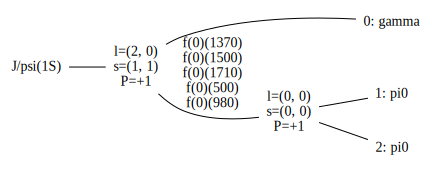

In [ ]:
result = q.generate_transitions(
    initial_state=("J/psi(1S)", [-1, +1]),
    final_state=["gamma", "pi0", "pi0"],
    allowed_intermediate_particles=["f(0)"],
    allowed_interaction_types=["strong", "EM"],
    formalism_type="canonical-helicity",
)
dot = q.io.asdot(result, collapse_graphs=True)
graphviz.Source(dot)

In [ ]:
model_builder = ampform.get_builder(result)
for name in result.get_intermediate_particles().names:
    model_builder.set_dynamics(name, create_relativistic_breit_wigner_with_ff)
model = model_builder.generate()

In [ ]:
model.components[
    R"A[J/\psi(1S)_{-1} \to f_{0}(980)_{0} \gamma_{+1,L=2,S=1}; f_{0}(980)_{0} \to \pi^{0}_{0} \pi^{0}_{0,L=0,S=0}]"
].doit()

sqrt(10)*C[J/\psi(1S) \to f_{0}(980)_{0} \gamma_{+1}; f_{0}(980) \to \pi^{0}_{0} \pi^{0}_{0}]*Gamma_f(0)(980)*m_f(0)(980)*(cos(theta_1+2)/2 + 1/2)*exp(-I*phi_1+2)/(10*(-I*Gamma_f(0)(980)*m_f(0)(980)*sqrt((m_12**2 - (m_1 - m_2)**2)*(m_12**2 - (m_1 + m_2)**2)/m_12**2)*sqrt(m_f(0)(980)**2)/(sqrt((m_f(0)(980)**2 - (m_1 - m_2)**2)*(m_f(0)(980)**2 - (m_1 + m_2)**2)/m_f(0)(980)**2)*Abs(m_12)) - m_12**2 + m_f(0)(980)**2))

### Generate data sample

:::{seealso}

{doc}`usage/step2`

:::

In [ ]:
%%time
sympy_model = SympyModel(
    expression=model.expression,
    parameters=model.parameter_defaults,
    max_complexity=500,
)
intensity = LambdifiedFunction(sympy_model, backend="jax")
data_converter = HelicityTransformer(model.adapter)

Splitting expression:   0%|          | 0/2187 [00:00<?, ?node/s]

Lambdifying sub-expressions:   0%|          | 0/40 [00:00<?, ?expr/s]

CPU times: user 3.84 s, sys: 43.6 ms, total: 3.88 s
Wall time: 4 s


In [ ]:
%%time
phsp_sample = generate_phsp(1_000_000, model.adapter.reaction_info)

Generating phase space sample:   0%|          | 0/20.0 [00:00<?, ?it/s]

CPU times: user 11.4 s, sys: 1.78 s, total: 13.2 s
Wall time: 4.81 s


In [ ]:
%%time
data_sample = generate_data(
    100_000, model.adapter.reaction_info, data_converter, intensity
)

Generating intensity-based sample:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 26.2 s, sys: 457 ms, total: 26.6 s
Wall time: 12.7 s


In [ ]:
import numpy as np
from matplotlib import cm

reaction_info = model.adapter.reaction_info
intermediate_states = sorted(
    (
        p
        for p in model.particles
        if p not in reaction_info.final_state.values()
        and p not in reaction_info.initial_state.values()
    ),
    key=lambda p: p.mass,
)

evenly_spaced_interval = np.linspace(0, 1, len(intermediate_states))
colors = [cm.rainbow(x) for x in evenly_spaced_interval]


def indicate_masses():
    plt.xlabel("$m$ [GeV]")
    for i, p in enumerate(intermediate_states):
        plt.gca().axvline(
            x=p.mass, linestyle="dotted", label=p.name, color=colors[i]
        )

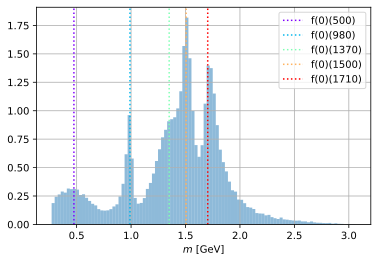

In [ ]:
phsp_set = data_converter.transform(phsp_sample)
data_set = data_converter.transform(data_sample)
data_frame = pd.DataFrame(data_set)
data_frame["m_12"].hist(bins=100, alpha=0.5, density=True)
indicate_masses()
plt.legend();

### Optimize the model

:::{seealso}

{doc}`usage/step3`

:::

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def compare_model(
    variable_name,
    data_set,
    phsp_set,
    intensity_model,
    bins=150,
):
    data = data_set[variable_name]
    phsp = phsp_set[variable_name]
    intensities = intensity_model(phsp_set)
    plt.hist(data, bins=bins, alpha=0.5, label="data", density=True)
    plt.hist(
        phsp,
        weights=intensities,
        bins=bins,
        histtype="step",
        color="red",
        label="initial fit model",
        density=True,
    )
    indicate_masses()
    plt.legend()

In [ ]:
estimator = UnbinnedNLL(
    intensity,
    data_set,
    phsp_set,
    backend="jax",
)
initial_parameters = {
    "m_f(0)(980)": 0.93,
    "m_f(0)(1500)": 1.45,
    "m_f(0)(1710)": 1.8,
    "Gamma_f(0)(980)": 0.1,
    "Gamma_f(0)(1710)": 0.2,
}
intensity.update_parameters(initial_parameters)

Number of free parameters: 5


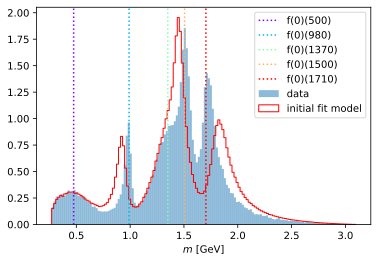

In [ ]:
compare_model("m_12", data_set, phsp_set, intensity)
print("Number of free parameters:", len(initial_parameters))

In [ ]:
callback = CSVSummary("fit_traceback.csv")
minuit2 = Minuit2(callback)
%time fit_result = minuit2.optimize(estimator, initial_parameters)
fit_result

0it [00:00, ?it/s]

CPU times: user 9min 47s, sys: 1.65 s, total: 9min 49s
Wall time: 1min 2s


FitResult(
 minimum_valid=True,
 execution_time=60.4040584564209,
 function_calls=267,
 estimator_value=-40174.268951052465,
 parameter_values={'m_f(0)(980)': 1.5063156093601726,
  'm_f(0)(1500)': 1.7031853673112354,
  'm_f(0)(1710)': 1.3402326921011354,
  'Gamma_f(0)(980)': 0.09281028069217315,
  'Gamma_f(0)(1710)': 1.0762607250008327},
 parameter_errors={'m_f(0)(980)': 0.0007228841125465936,
  'm_f(0)(1500)': 0.0007917682088784476,
  'm_f(0)(1710)': 0.007298199749880446,
  'Gamma_f(0)(980)': 0.002438590384690689,
  'Gamma_f(0)(1710)': 0.01525742482720339},
)

CPU times: user 4.97 s, sys: 91.7 ms, total: 5.06 s
Wall time: 3.18 s


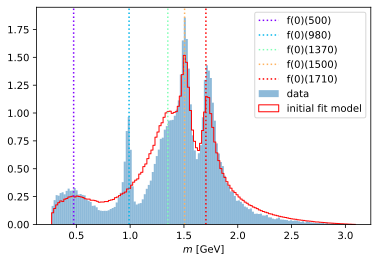

In [ ]:
optimized_parameters = fit_result.parameter_values
intensity.update_parameters(optimized_parameters)
%time compare_model("m_12", data_set, phsp_set, intensity)

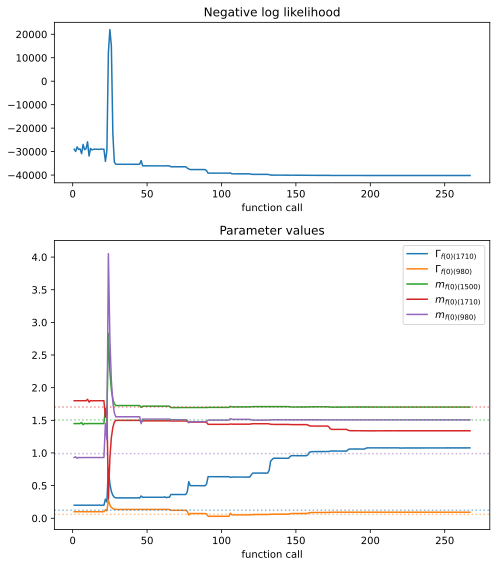

In [ ]:
import pandas as pd
import sympy as sp

converters = {p: lambda s: complex(s).real for p in initial_parameters}
fit_traceback = pd.read_csv("fit_traceback.csv", converters=converters)
fig, (ax1, ax2) = plt.subplots(
    2, figsize=(7, 8), gridspec_kw={"height_ratios": [1, 1.8]}
)
fit_traceback.plot("function_call", "estimator_value", ax=ax1)
fit_traceback.plot("function_call", sorted(initial_parameters), ax=ax2)
ax1.set_title("Negative log likelihood")
ax2.set_title("Parameter values")
ax1.set_xlabel("function call")
ax2.set_xlabel("function call")
fig.tight_layout()
ax1.legend().remove()
legend_texts = ax2.legend().get_texts()
for text in legend_texts:
    latex = f"${sp.latex(sp.Symbol(text.get_text()))}$"
    latex = latex.replace("\\\\", "\\")
    if latex[2] == "C":
        latex = fR"\left|{latex}\right|"
    text.set_text(latex)
for line in ax2.get_lines():
    label = line.get_label()
    color = line.get_color()
    ax2.axhline(
        y=complex(sympy_model.parameters[label]).real,
        color=color,
        alpha=0.5,
        linestyle="dotted",
    )

## Step-by-step workflow

The following pages go through the usual workflow when using {mod}`tensorwaves`. The output in each of these steps is written to disk, so that each notebook can be run separately.

```{toctree}
---
maxdepth: 2
---
usage/step1
usage/step2
usage/step3
usage/basics
usage/faster-lambdify
```